In [62]:
import json
import pandas as pd
from typing import Any, Dict, List, Tuple
import requests
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots


def process_nvd_json(file_path: str) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """
    Process an NVD JSON file and convert it to two normalized DataFrames:
    1. Main CVE DataFrame
    2. CPE matches DataFrame with foreign key to CVE
    """
    # Read the JSON file
    with open(file_path, 'r', encoding='ISO-8859-1') as f:
        nvd_data = json.load(f)
    
    # Lists to store processed items
    cve_items: List[Dict[str, Any]] = []
    cpe_items: List[Dict[str, Any]] = []
    
    for cve_item in nvd_data['CVE_Items']:
        cve_data: Dict[str, Any] = {}
        
        # Basic CVE information
        cve_id = cve_item['cve']['CVE_data_meta']['ID']
        cve_data['id'] = cve_id
        cve_data['assigner'] = cve_item['cve']['CVE_data_meta'].get('ASSIGNER', '')
        cve_data['published_date'] = cve_item.get('publishedDate', None)
        cve_data['last_modified_date'] = cve_item.get('lastModifiedDate', None)
        
        # Description
        descriptions = cve_item['cve']['description']['description_data']
        cve_data['description'] = next(
            (desc['value'] for desc in descriptions if desc.get('lang') == 'en'), ''
        )
        
        # Problem type (CWE)
        try:
            problemtype_data = cve_item['cve']['problemtype']['problemtype_data']
            if problemtype_data and problemtype_data[0].get('description'):
                cve_data['cwe'] = problemtype_data[0]['description'][0].get('value', '')
            else:
                cve_data['cwe'] = ''
        except (KeyError, IndexError):
            cve_data['cwe'] = ''
        
        # References
        try:
            references = cve_item['cve']['references']['reference_data']
            cve_data['references'] = '; '.join(ref.get('url', '') for ref in references)
        except (KeyError, IndexError):
            cve_data['references'] = ''
        
        # CVSS v3 metrics
        try:
            cvss3 = cve_item['impact']['baseMetricV3']['cvssV3']
            cve_data['cvss3_vector'] = cvss3.get('vectorString', '')
            cve_data['cvss3_base_score'] = cvss3.get('baseScore', None)
            cve_data['cvss3_base_severity'] = cvss3.get('baseSeverity', '')
        except (KeyError, TypeError):
            cve_data.update({
                'cvss3_vector': '',
                'cvss3_base_score': None,
                'cvss3_base_severity': ''
            })
        
        # Process CPE matches
        try:
            nodes = cve_item['configurations']['nodes']
            for node in nodes:
                for cpe in node.get('cpe_match', []):
                    cpe_info: Dict[str, Any] = {
                        'cve_id': cve_id,
                        'cpe23Uri': cpe.get('cpe23Uri', ''),
                        'vulnerable': cpe.get('vulnerable', False),
                        'versionStartIncluding': cpe.get('versionStartIncluding', ''),
                        'versionEndIncluding': cpe.get('versionEndIncluding', '')
                    }
                    cpe_parts = cpe_info['cpe23Uri'].split(':')
                    if len(cpe_parts) > 4:
                        cpe_info.update({
                            'vendor': cpe_parts[3],
                            'product': cpe_parts[4],
                            'version': cpe_parts[5]
                        })
                    cpe_items.append(cpe_info)
        except (KeyError, TypeError):
            pass
        
        cve_items.append(cve_data)
    
    # Create DataFrames
    cve_df = pd.DataFrame(cve_items)
    cpe_df = pd.DataFrame(cpe_items)
    
    # Convert date columns to datetime
    for col in ['published_date', 'last_modified_date']:
        cve_df[col] = pd.to_datetime(cve_df[col], errors='coerce')
    
    # Convert CVSS score to numeric
    cve_df['cvss3_base_score'] = pd.to_numeric(cve_df['cvss3_base_score'], errors='coerce')
    
    # Sort DataFrames
    cve_df = cve_df.sort_values('id')
    cpe_df = cpe_df.sort_values(['cve_id', 'cpe23Uri'])
    return cve_df, cpe_df


def process_cwe_API():
    url = "https://cwe-api.mitre.org/api/v1/cwe/weakness/all"
    resp = requests.get(url)
    cwe_raw  = resp.json()
    weakness_list = cwe_raw["Weaknesses"]
    cwe_df = pd.json_normalize(weakness_list)
    cwe_df.to_csv("cwe_data.csv", index=False)
    
    return cwe_df



In [64]:
cve_df_2024, cpe_df_2024 = process_nvd_json("nvdcve-1.1-2024.json")
cve_df_2024.to_csv("processed_cve_data_2024.csv", index=False)
cpe_df_2024.to_csv("processed_cpe_data_2024.csv", index=False)

cve_df_2023, cpe_df_2023 = process_nvd_json("nvdcve-1.1-2023.json")
cve_df_2023.to_csv("processed_cve_data_2023.csv", index=False)
cpe_df_2023.to_csv("processed_cpe_data_2023.csv", index=False)

cve_df_2022, cpe_df_2022 = process_nvd_json("nvdcve-1.1-2022.json")
cve_df_2022.to_csv("processed_cve_data_2022.csv", index=False)
cpe_df_2022.to_csv("processed_cpe_data_2022.csv", index=False)

kev_df = pd.read_csv('known_exploited_vulnerabilities.csv')

cwe_df = process_cwe_API()


## 2. Data Cleaning and Transformation

In [101]:
#Sets columns to datatime objects and numeric objects for better processing and analysis across
# all datasets 
cve_df_2024['published_date'] = pd.to_datetime(cve_df_2024['published_date'], errors='coerce')
cve_df_2024['last_modified_date'] = pd.to_datetime(cve_df_2024['last_modified_date'], errors='coerce')
cve_df_2024['cvss3_base_score'] = pd.to_numeric(cve_df_2024['cvss3_base_score'], errors='coerce')
cve_df_2024.dropna(subset=['published_date'], inplace=True)

cpe_df_2024.drop_duplicates(subset=['cve_id', 'cpe23Uri'], inplace=True)

cve_df_2023['published_date'] = pd.to_datetime(cve_df_2023['published_date'], errors='coerce')
cve_df_2023['last_modified_date'] = pd.to_datetime(cve_df_2023['last_modified_date'], errors='coerce')
cve_df_2023['cvss3_base_score'] = pd.to_numeric(cve_df_2023['cvss3_base_score'], errors='coerce')
cve_df_2023.dropna(subset=['published_date'], inplace=True)

cpe_df_2023.drop_duplicates(subset=['cve_id', 'cpe23Uri'], inplace=True)

cve_df_2022['published_date'] = pd.to_datetime(cve_df_2022['published_date'], errors='coerce')
cve_df_2022['last_modified_date'] = pd.to_datetime(cve_df_2022['last_modified_date'], errors='coerce')
cve_df_2022['cvss3_base_score'] = pd.to_numeric(cve_df_2022['cvss3_base_score'], errors='coerce')
cve_df_2022.dropna(subset=['published_date'], inplace=True)

cpe_df_2022.drop_duplicates(subset=['cve_id', 'cpe23Uri'], inplace=True)

# Renaming the columns for clarity
kev_df.rename(columns={'cveID':'id', 'dateAdded':'kev_added_date'}, inplace=True)
#Coverts to a data time object
kev_df['kev_added_date'] = pd.to_datetime(kev_df['kev_added_date'], errors='coerce')
kev_df = kev_df.dropna(subset=['cwes'])

cwe_df.drop_duplicates(subset=["ID"], inplace=True)


### Merging KEV and CWE data frames

In [431]:
kev_df['CWE_ID_Numeric'] = kev_df['cwes'].str.findall(r"CWE-(\d+)")
kev_df = kev_df.explode('CWE_ID_Numeric')

kev_df = kev_df.dropna(subset=['CWE_ID_Numeric'])   
kev_df['CWE_ID_Numeric'] = kev_df['CWE_ID_Numeric'].astype(int)

cwe_df = pd.read_csv("cwe_data.csv")
cwe_df['ID'] = pd.to_numeric(cwe_df['ID'], errors='coerce').astype(int)


kev_cwe_combined = kev_df.merge(cwe_df,
    how='left',
    left_on='CWE_ID_Numeric',
    right_on='ID')


### Merging NVD 2022-2024 with kev_cwe_combined

In [70]:
drop_dupes = kev_cwe_combined.drop_duplicates(subset=['id'], keep='first')

all_cve_data = pd.concat([cve_df_2022, cve_df_2023, cve_df_2024],ignore_index=True)

all_cpe_data = pd.concat([cpe_df_2022, cpe_df_2023, cpe_df_2024],ignore_index=True)

master_analysis_data = all_cve_data.merge(drop_dupes, on='id', how='left')

master_analysis_data.to_csv("Master_Analysis_Data.csv", index=False)


### New Features

In [72]:
# Find vulnerabilities that have known exploits
master_analysis_data['has_known_exploit'] = master_analysis_data['kev_added_date'].notna()


In [73]:
#Groups vulnerabilities into a severity level range and sets a label to the severity
severity_range = [0.0, 0.1, 4.0, 7.0, 9.0, 10.0]
range_labels = ['Informational', 'Low', 'Medium', 'High', 'Critical']

master_analysis_data['cvss3_severity_level'] = pd.cut(
    master_analysis_data['cvss3_base_score'],
    bins= severity_range,
    labels= range_labels,
    include_lowest=True)

master_analysis_data[['id','cvss3_base_score','cvss3_severity_level']].head()

,id,cvss3_base_score,cvss3_severity_level
0,CVE-2022-0001,6.5,Medium
1,CVE-2022-0002,6.5,Medium
2,CVE-2022-0004,6.8,Medium
3,CVE-2022-0005,2.4,Low
4,CVE-2022-0010,5.5,Medium


In [74]:
# Gets the current date 
today = pd.Timestamp.now(master_analysis_data['published_date'].dt.tz)

# Computes age in days from the published date to the current date
master_analysis_data['vulnerability_age'] = (today - master_analysis_data['published_date']).dt.days

master_analysis_data[['id', 'published_date', 'vulnerability_age']].head()


,id,published_date,vulnerability_age
0,CVE-2022-0001,2022-03-11 18:15:00+00:00,1152
1,CVE-2022-0002,2022-03-11 18:15:00+00:00,1152
2,CVE-2022-0004,2022-05-12 17:15:00+00:00,1090
3,CVE-2022-0005,2022-05-12 17:15:00+00:00,1090
4,CVE-2022-0010,2023-05-22 08:15:00+00:00,716


In [75]:
# Sets the amount of time between the day the vulnerability was published and when it was last modified
# to a new column called time_to_modify
master_analysis_data['time_to_modify'] = ( pd.to_datetime(master_analysis_data['last_modified_date'], errors='coerce')
                                         - pd.to_datetime(master_analysis_data['published_date'], errors='coerce')).dt.days

print(master_analysis_data['time_to_modify'].describe())

count    93522.000000
mean       403.127104
std        317.735042
min          0.000000
25%        131.000000
50%        351.000000
75%        671.000000
max       1211.000000
Name: time_to_modify, dtype: float64


In [76]:
# Changes published_data to be tz-naive now so you can subtract the two columns
master_analysis_data['published_date'] = (master_analysis_data['published_date'].dt.tz_localize(None))

#Gets the time to exploit in days
master_analysis_data['time_to_exploit'] = (master_analysis_data['kev_added_date']
                                               - master_analysis_data['published_date']).dt.days

## 3. Exploratory Data Analysis and Visualization:

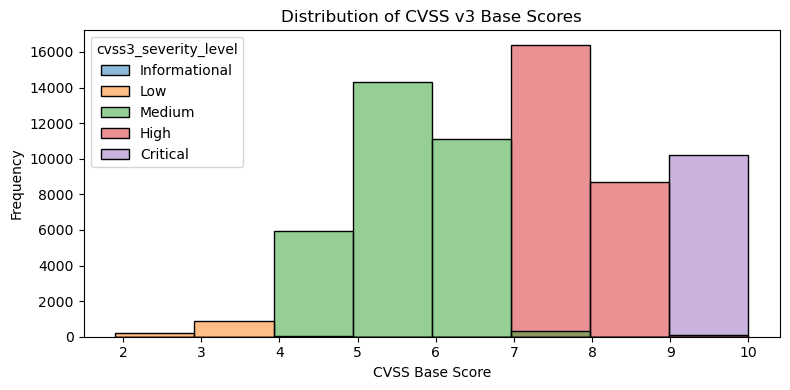

In [78]:
master_data_clean = master_analysis_data.dropna(subset=["cvss3_base_score", "published_date", 'cvss3_severity_level']).copy()

plt.figure(figsize=(8, 4))
plt.subplot(1,1,1)       
sns.histplot(data = master_data_clean, x = "cvss3_base_score", binwidth = 1, hue = "cvss3_severity_level")
plt.title("Distribution of CVSS v3 Base Scores")
plt.xlabel("CVSS Base Score")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

### Intepretation
The histogram makes clear that the majority of CVEs fall into the medium severity bins (scores 4–7). Low‐severity and informational issues (scores below 4) are uncommon, while high‐severity (7–9) vulnerabilities are almost as frequent as their medium-severity counterparts. The critcal severity vulnerabilities also make up a good chunk of the vulnerabilities in the dataset. The 7-8 bin has the highest frequency, reaching nearly 16,000 vulnerabilities. This right-skewed distribution tells us that new entries in the database are far more likely to be moderate or high risk—and thus demand swift remediation—than truly low-risk cases.

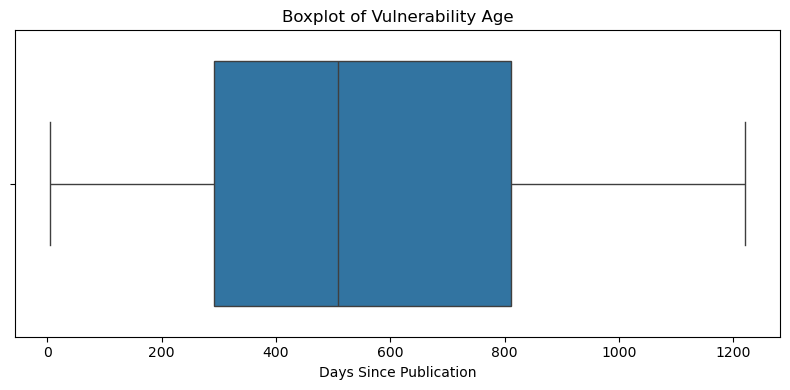

In [80]:
plt.figure(figsize=(8, 4))
sns.boxplot(x=master_analysis_data["vulnerability_age"].dropna())
plt.title("Boxplot of Vulnerability Age")
plt.xlabel("Days Since Publication")
plt.tight_layout()
plt.show()

### Interpretation
The boxplot of vulnerability age reveals that half of all CVEs in the dataset were published between 350 and 800 days ago, with a median of about 500 days. The lower whisker drops down near 0 days, indicating some very recent disclosures, while the upper whisker stretches out to around 1,250 days, showing the oldest reported vulnerabilities. Altogether, this distribution tells us that while new vulnerabilities continue to be added, the bulk of our data consists of issues disclosed in the last two years.

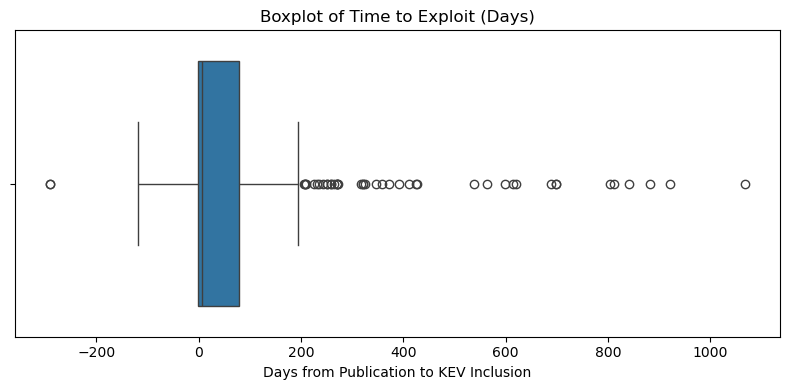

In [82]:
plt.figure(figsize=(8,4))
sns.boxplot(x=master_analysis_data["time_to_exploit"].dropna())
plt.title("Boxplot of Time to Exploit (Days)")
plt.xlabel("Days from Publication to KEV Inclusion")
plt.tight_layout()
plt.show()

### Interpretation

The boxplot of time-to-exploit shows that half of all exploited CVEs are exploited within roughly 0 to 150 days of publication, with a median of about 75 days. This right-skewed pattern tells us that once a flaw hits the database, it will most likely be exploited quickly.

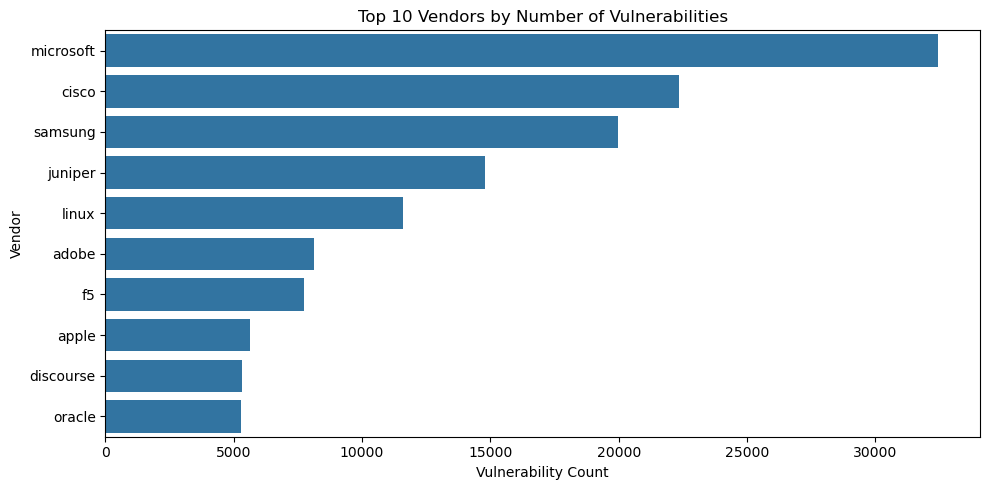

In [84]:
top_vendors = all_cpe_data["vendor"].value_counts().nlargest(10)
plt.figure(figsize=(10,5))
sns.barplot(x = top_vendors.values, y =top_vendors.index)
plt.title("Top 10 Vendors by Number of Vulnerabilities")
plt.xlabel("Vulnerability Count")
plt.ylabel("Vendor")
plt.tight_layout()
plt.show()

### Interpretation
The visualization here shows the total number of vulnerabilities that affect the top 10 vendors in terms of vulnerabilities.
As you can see from the visualization, Microsoft has the highest number, most likely due to Windows being the most run operating system in the world.
The next highest Cisco is almost 50% less than Microsoft in total count, and from there the list steadily declines after Samsung.

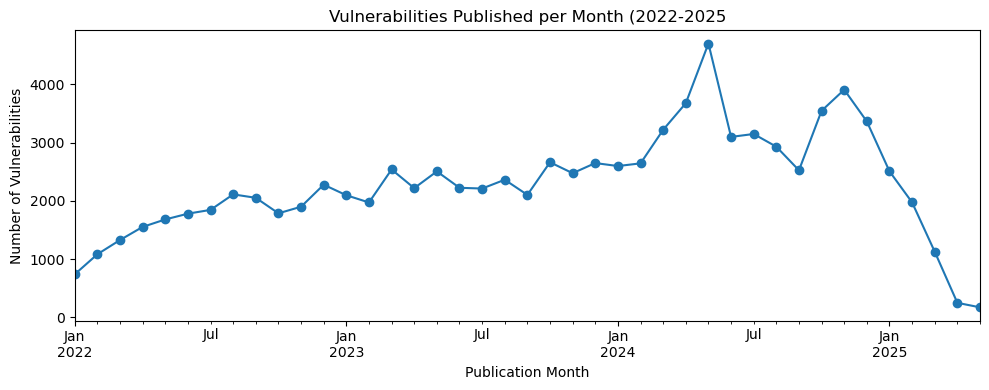

In [104]:
vulnerability_count= (master_analysis_data
                  .set_index('published_date')
                  .resample('ME')       
                  .size())

plt.figure(figsize=(10,4))
vulnerability_count.plot(marker='o')
plt.title('Vulnerabilities Published per Month (2022-2025')
plt.xlabel('Publication Month')
plt.ylabel('Number of Vulnerabilities')
plt.tight_layout()
plt.show()

### Interpretation

The chart shows that roughly 2,000 new CVEs are published each month on average. In early 2022, that number often sat below 2,000, but by late 2023 and into 2024, most months are above it. The clear peak seems to be in the late spring of 2024, with the count reaching well over 4,000 vulnerabilities published. Overall, the line trends upward, which means vulnerabilities are coming faster over time. 

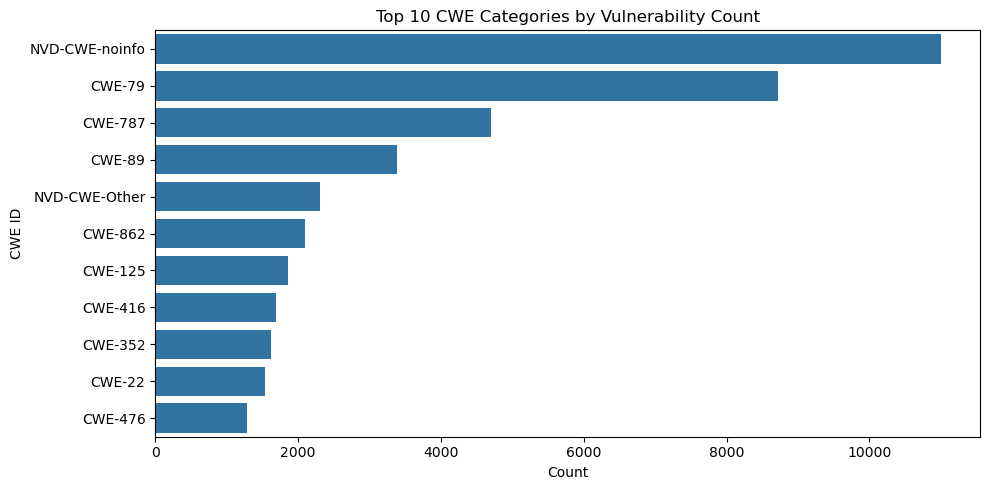

In [126]:
cwe_counts = master_analysis_data["cwe"].dropna().value_counts()
# Filters out the empty strings that were showing up in the count
cwe_counts_filtered = cwe_counts.iloc[1:12]

plt.figure(figsize=(10, 5))
sns.barplot(x = cwe_counts_filtered.values, y = cwe_counts_filtered.index)
plt.title("Top 10 CWE Categories by Vulnerability Count")
plt.xlabel("Count")
plt.ylabel("CWE ID")
plt.tight_layout()
plt.show()

### Interpretation

NVD-CWE-noinfo tops the list by a mile with over 30,000 CVEs with no specific CWE. CWE-79 (Cross-site Scripting) comes next at about 10,000, followed by CWE-787 (Out-of-Bounds Write) and CWE-89 (SQL Injection) in the 4–5,000 range. Overall, Cross-Site Scripting looks to be the most used vulnerability, with attackers being able to take advantage of software and users with malicious input.

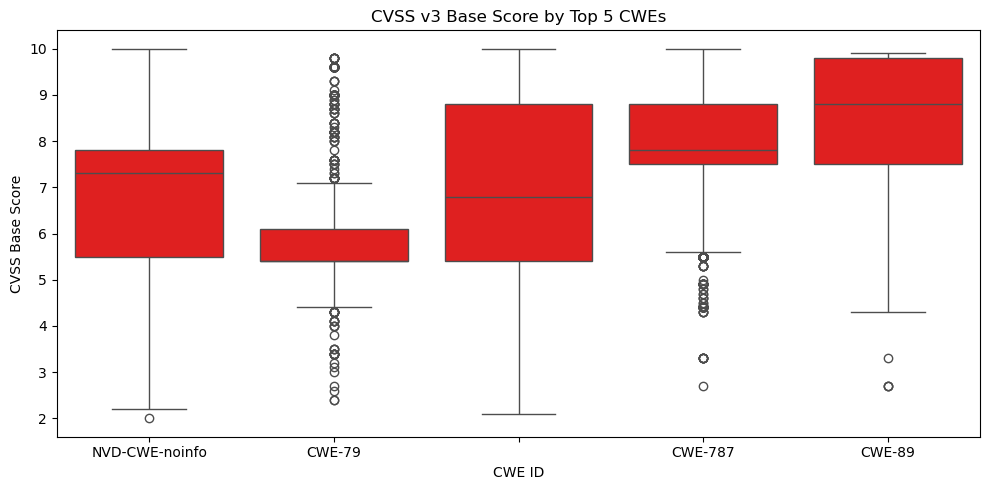

In [157]:
top_5_cwes = cwe_counts.nlargest(5) 

plt.figure(figsize=(10, 5))
sns.boxplot(
    data = master_analysis_data[master_analysis_data["cwe"].isin(top_5_cwes.index)],
    x="cwe",
    y="cvss3_base_score",
    color = 'red')

plt.title("CVSS v3 Base Score by Top 5 CWEs")
plt.xlabel("CWE ID")
plt.ylabel("CVSS Base Score")
plt.tight_layout()
plt.show()

### Analysis

The boxplot shows that unclassified CVEs have a median of just over 7, putting them in the high severity category, but they do span from about 2 up to 10. CWE-79 vulnerabilities have a median of around 5–6, so they tend to be medium-impact. Vulnerabilities classified as CWE-787 sit around a score of 8, putting it in the upper range of high severity. Lastly, CWE-89, which are SQL injections, are the most severe, with a median of 9 putting the average score in the critical category. 

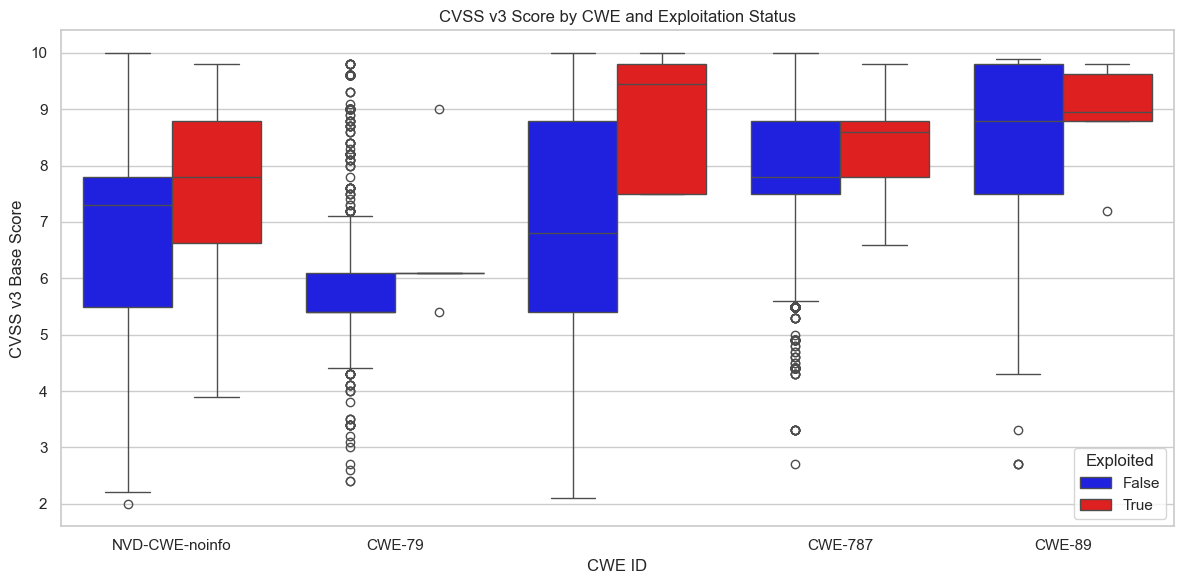

In [433]:
top5 = master_analysis_data["cwe"].value_counts().nlargest(5).index.tolist()

plt.figure(figsize=(12,6))
sns.boxplot(
    data = master_analysis_data[master_analysis_data["cwe"].isin(top5)],
    x = "cwe",
    y = "cvss3_base_score",
    hue = "has_known_exploit",
    palette = ["blue", "red"])

plt.title("CVSS v3 Score by CWE and Exploitation Status")
plt.xlabel("CWE ID")
plt.ylabel("CVSS v3 Base Score")
plt.legend(title = "Exploited", loc = "lower right")
plt.tight_layout()
plt.show()

### Analysis

The boxes make it clear that exploited CVEs almost always have a higher severity on the CVSS scale than their non-exploited counterparts. For example, the noinfo group's exploited flaws sit around a 7.8 median compared to about 7.2 for the non-exploited. CWE-79's jumps from about 5.7 up to about 6.1, while CWE-787's moves from 7.8 to nearly 8.8. The SQL injections (CWE-89) non-exploited ones hover around 8, reach critical levels, reaching almost the highest score of 10. Overall, the higher the CVSS score, the more likely attackers are to exploit a vulerability.

## 4. Descriptive Statistics:

In [197]:
# Mean
mean_cvss = master_analysis_data["cvss3_base_score"].mean()
print("Mean CVSS3 Base Score: ", round(mean_cvss, 2))

# Median
median_cvss = master_analysis_data["cvss3_base_score"].median()
print("Median CVSS3 Base Score: ", median_cvss)

# Standard Deviation
std_cvss = master_analysis_data["cvss3_base_score"].std()
print("Standard Devation of CVSS3 Base Scores: ", round(std_cvss, 2))

Mean CVSS3 Base Score:  7.06
Median CVSS3 Base Score:  7.2
Standard Devation of CVSS3 Base Scores:  1.72


In [216]:
master_analysis_data["year"] = master_analysis_data["published_date"].dt.year
vuln_per_year = master_analysis_data["year"].value_counts().sort_index()
print("Vulnerabilities per year:")
print(vuln_per_year, "\n")


Vulnerabilities per year:
year
2022    20136
2023    28012
2024    39344
2025     6030
Name: count, dtype: int64 



In [321]:
# Merges the two main datasets based on the id, year, and vendors 
# to get one dataset that has the year, the vendor, and the number of vulnerabilities
vendor_merged = pd.merge(
    master_analysis_data[['id','year']],
    all_cpe_data[['cve_id','vendor']],
    left_on='id',
    right_on='cve_id',
    how='inner')

vendor_merged = vendor_merged.drop_duplicates(subset=['id','vendor','year'])

top10 = (vendor_merged['vendor']
        .value_counts()
        .nlargest(10)
        .index
        .tolist())

in_top10 = vendor_merged[vendor_merged['vendor'].isin(top10)]

yearly_counts = (
    in_top10
      .groupby(['vendor','year'])['id']
      .nunique()
      .reset_index(name = 'vulnerability_count')
      .sort_values(['vendor','year'])
)

print(yearly_counts)
    

           vendor  year  vulnerability_count
0           adobe  2022                   80
1           adobe  2023                  316
2           adobe  2024                  487
3           adobe  2025                   10
4           apple  2022                  450
5           apple  2023                  480
6           apple  2024                  591
7           apple  2025                   61
8          debian  2022                  740
9          debian  2023                  492
10         debian  2024                  275
11         debian  2025                    1
12  fedoraproject  2022                  792
13  fedoraproject  2023                  543
14  fedoraproject  2024                  258
15         google  2022                 1163
16         google  2023                  894
17         google  2024                  478
18         google  2025                    3
19            ibm  2022                  148
20            ibm  2023                  217
21        

In [311]:
vulnerabilities_per_product = all_cpe_data.groupby("product")["cve_id"].nunique().sort_values(ascending=False)
print("Number of Vulnerabilities per product (top 10 unique CVEs)")
print(vulnerabilities_per_product.head(10))

Number of Vulnerabilities per product (top 10 unique CVEs)
product
linux_kernel           3966
android                1884
windows_server_2019    1680
fedora                 1591
windows_server_2022    1578
windows_server_2016    1511
debian_linux           1507
macos                  1353
windows_server_2012    1277
windows_11_22h2        1051
Name: cve_id, dtype: int64


In [252]:
cwe_counts = master_analysis_data["cwe"].fillna("UNSPECIFIED").value_counts()
print("Vulnerabilities per CWE category:")
print(cwe_counts.head(20), "\n") 

Vulnerabilities per CWE category:
cwe
                  32737
NVD-CWE-noinfo    10998
CWE-79             8724
CWE-787            4702
CWE-89             3382
NVD-CWE-Other      2305
CWE-862            2102
CWE-125            1858
CWE-416            1691
CWE-352            1625
CWE-22             1542
CWE-476            1282
CWE-78             1183
CWE-434             908
CWE-120             898
CWE-77              678
CWE-20              660
CWE-287             604
CWE-863             573
CWE-362             545
Name: count, dtype: int64 



In [319]:
exploit_counts_by_cwe = (master_analysis_data 
                         [master_analysis_data['has_known_exploit']]
                         .groupby('cwe')['id']
                         .nunique().sort_values(ascending=False))

print("Count of CVEs with known exploits, by CWE category:")
print(exploit_counts_by_cwe.head(20))

Count of CVEs with known exploits, by CWE category:
cwe
NVD-CWE-noinfo    51
CWE-787           39
CWE-78            28
NVD-CWE-Other     26
CWE-416           23
CWE-22            19
CWE-306           17
                  17
CWE-94            16
CWE-843           15
CWE-287           11
CWE-77            11
CWE-502           10
CWE-79             8
CWE-863            7
CWE-89             6
CWE-190            5
CWE-119            4
CWE-798            4
CWE-125            4
Name: id, dtype: int64


In [335]:
total_cves = len(master_analysis_data)
exploited_cves = master_analysis_data['has_known_exploit'].sum()

percent_exploited = (exploited_cves / total_cves) * 100
print("Percentage of CVEs with known exploits: ", round(percent_exploited, 2))

Percentage of CVEs with known exploits:  0.42


In [368]:
cwe_df = master_analysis_data[['id', 'cwe']]

cwe_merged = pd.merge(
    cwe_df,
    all_cpe_data[['cve_id', 'vendor']],
    left_on='id',
    right_on='cve_id',
    how='inner')

# Gets the top CWES for Microsoft
ms_counts =(
    cwe_merged[cwe_merged['vendor'].str.contains('microsoft', case=False)] ['cwe']
      .value_counts()
      .nlargest(10))

print("Top CWEs for Microsoft:", ms_counts, "\n")

# Top CWEs for Cisco
cisco_counts = (
    cwe_merged[cwe_merged['vendor'].str.contains('cisco', case=False)]
      ['cwe']
      .value_counts()
      .nlargest(10)
)
print("Top CWEs for Cisco:", cisco_counts, "\n")

samsung_counts = (
    cwe_merged[cwe_merged['vendor'].str.contains('samsung', case=False)]
      ['cwe']
      .value_counts()
      .nlargest(10))
print("Top CWEs for Samsung:", samsung_counts, "\n")

linux_counts = (
    cwe_merged[cwe_merged['vendor'].str.contains('linux', case=False)]
      ['cwe']
      .value_counts()
      .nlargest(10))
print("Top CWEs for Linux:", linux_counts, "\n")



Top CWEs for Microsoft: cwe
NVD-CWE-noinfo    27751
CWE-362            1745
CWE-787             410
CWE-269             316
CWE-125             225
NVD-CWE-Other       206
CWE-416             182
CWE-668             170
CWE-59              154
CWE-190             110
Name: count, dtype: int64 

Top CWEs for Cisco: cwe
CWE-787           3917
CWE-79            3662
NVD-CWE-noinfo    3538
CWE-755           1552
CWE-78            1159
CWE-129            852
CWE-22             848
CWE-863            801
CWE-352            627
CWE-772            612
Name: count, dtype: int64 

Top CWEs for Samsung: cwe
NVD-CWE-noinfo    5528
CWE-787           5104
NVD-CWE-Other     3220
CWE-287           1095
CWE-125            829
CWE-20             782
CWE-863            553
CWE-276            469
CWE-22             404
CWE-269            315
Name: count, dtype: int64 

Top CWEs for Linux: cwe
CWE-476           2184
NVD-CWE-noinfo    1812
CWE-416           1500
                  1058
CWE-401            858

# 5. Exploratory Inferences:

### 1. Top Vendors and Their CWE Weaknesses

Microsoft has by far the most reported vulnerabilities, with over 30,000 published across the databases. The top weakness we see in Microsoft is from CWE-362, which is known as a "race condition", meaning that an attacker can insert malicious code during an authentication process to then be able to give themselves elevated privileges. The next weakness is one of the most reported CWEs: CWE 787. This CWE exploits the buffer of a system by writing data before or after where it's supposed to be, allowing an attacker to crash the system or take control of the program.

Cisco also falls victim to CWE-787, as well as the most commonly published CWE: CWE-79. The CWE-79 vulnerability is when a user can inject scripts into a web page or application. When another person interacts with the infected web page the attacker's script is executed and does its intended purpose, usually stealing data from the user. 

Samsung, similarly to the other vendors, is also commonly affected by CWE-787 as well as CWE-287. CWE-287 is a big one as it relates to improper authentication of a user. This vulnerability allows attackers to gain access or permission without the proper information or authentication needed.

Linux is most vulnerable to CWE-476 and CWE-416. These CWEs are known as Null Pointer Dereference and Use After Free. For the Null Pointer vulnerability, it is when the system is trying to use a null pointer, allowing attackers to take advantage of this and potentially force system crashes. For CWE-416, it means the system is trying to use a piece of data that has already been used and released to the system. This vulnerability can cause data corruption and potentially crash the system.

From analysing these common CWEs in these top vendors, we can see that certain issues are persistent across all systems. For example, CWE-787 is among the top-most reported CWEs across these vendors, meaning that out-of-bounds and buffer issues are huge problems for most vendors. We can also see that web applications and APIs are common targets for attackers to insert malicious code and take advantage of anyone who interacts with these infected pages. The main takeaway is that these problems aren't simple plug-and-patch issues, but vulnerabilities that are evolving every day in a digital age where technology gets more and more sophisticated, showing that they need to be kept consistently updated and monitored. 


### 2. The relationship between vulnerability age, exploitability, and the time it takes to get exploited 

In [414]:
top10_cwes = master_analysis_data[master_analysis_data["cwe"]
            .isin(master_analysis_data["cwe"]
            .value_counts()     
            .nlargest(10)           
            .index[1:])] 

avg_age = top10_cwes.groupby("cwe")["vulnerability_age"].mean()

exploit_rate = (top10_cwes.groupby("cwe")["has_known_exploit"].mean() * 100)

avg_time = (top10_cwes[top10_cwes["has_known_exploit"]].groupby("cwe")["time_to_exploit"].mean())

age_and_exploitablity = pd.concat([avg_age, exploit_rate, avg_time], axis = 1, keys = ["avg_age","exploit_rate","avg_time_to_exploit"]).round(1)

print(age_and_exploitablity)

                avg_age  exploit_rate  avg_time_to_exploit
cwe                                                       
CWE-125           636.5           0.2                  5.5
CWE-352           519.9           0.0                  NaN
CWE-416           610.1           1.4                 36.8
CWE-787           677.5           0.8                  5.7
CWE-79            517.4           0.1                176.9
CWE-862           468.1           0.0                 37.0
CWE-89            654.4           0.2                 29.7
NVD-CWE-Other     659.7           1.1                 70.6
NVD-CWE-noinfo    620.4           0.5                 61.4


Out-of-bounds writes vulnerabilities (CWE-125 and CWE-787) turn into real-world attacks the fastest, with a turnaround of 5 to 6 days. Luckily, only 0.2–0.8% ever reach the point of being exploited. Use After Free bugs (CWE-416) take a bit longer, around 37 days, but they do have an exploit rate of 1.4%, putting them on the higher end for vulnerabilities. This means if an exploit does exist, it has a much higher chance of being exploited and on the faster side. SQL injection (CWE-89) flaws on average turn into exploits after roughly 30 days; however, only 0.2% become exploited issues. 
The rest of the CWEs either have an almost zero exploit rate, aren't fully defined (Other and noinfo), and/or their an average time to exploit in the range of months (CWE-79 cross-site scripting).

All of these weaknesses sit in our dataset at an average age of around 600–700 days. What really drives risk is how fast they get weaponized once discovered. Overall, when the report of vulnerabilities is given, the first patch wave needs to prioritize the exploits that are exploited the fastest, like the Out-of-bounds vulnerabilities, and then after that we can move onto the ones with the higher usage rates. 

### 3. Evaluating the impact of CVSS score on vulnerability exploitation and CWE prevalence.

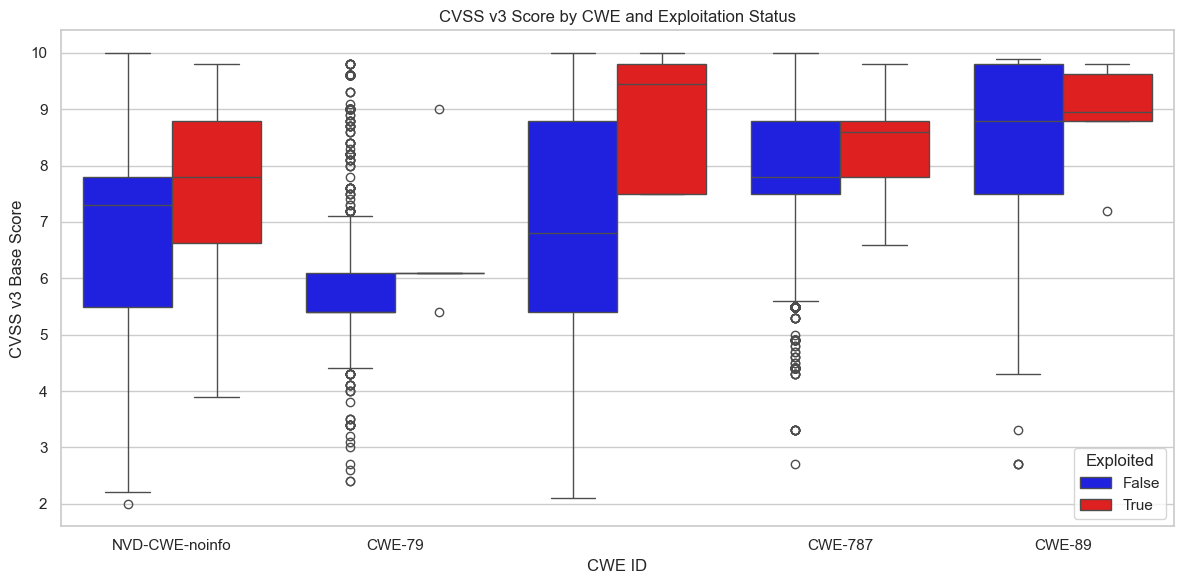

In [420]:
top5 = master_analysis_data["cwe"].value_counts().nlargest(5).index.tolist()

plt.figure(figsize=(12,6))
sns.boxplot(
    data = master_analysis_data[master_analysis_data["cwe"].isin(top5)],
    x = "cwe",
    y = "cvss3_base_score",
    hue = "has_known_exploit",
    palette = ["blue", "red"])

plt.title("CVSS v3 Score by CWE and Exploitation Status")
plt.xlabel("CWE ID")
plt.ylabel("CVSS v3 Base Score")
plt.legend(title = "Exploited", loc = "lower right")
plt.tight_layout()
plt.show()

Critical CWEs (9.0–10.0) are the vulnerabilities that attackers turn into real exploits the most. The most used and prevalent of the critical ranges are CWE-89 and CWE-787, which consist of SQL injections and out-of-bounds write. The chart shows that for these CWEs for the higher their severity score is the more likely it is to be exploited.

High‐severity issues (7.0–8.9) still draw serious attention from attackers and can cause just as much damage as the critical vulnerabilities. Most are out‐of‐bounds writes or use-after-free errors, with race conditions and unauthorized-privilage bugs close behind in terms of prevalence and exploitability rates.

Medium‐severity CVEs (4.0–6.9) are rarely exploited and used in attacks. In the rare instance that one is used, it is most likely to be through cross-site scripting due to the heavy publication of CWE-79.

Low‐severity flaws (<4.0) are already fairly uncommon, and the risk of being exploited is near zero. These are minor bugs that pose very little risk and are not worth the time of an attacker to try to exploit.

Overall, there is a clear impact of the CVSS score on the exploitation of a vulnerability, with the higher the score the more likely it will be exploited. This can be due to two reasons: in that for one, it is easy to exploit, and/or, if exploited, the reward or damage the attacker can cause is worth the effort needed. In short, by focusing first on Critical and High CVSS issues, you’ll block the vast majority of real‐world exploits. From then you can focus on cleaning up some of the smaller less severe vulnerabilities.

### 4. Risk Factors

The single biggest risk factor is a high to critical CVSS score paired with a memory-corruption or injection weakness. Those critical and high-severity flaws get exploited very quickly after being added to the database. Our time-to-exploit data shows that newly published vulnerabilities in those same CWE classes are often exploited within days or weeks. So, as soon as these types of vulnerabilities are discovered, it is essential to put the time and resources toward fixing the issue as quickly as possible before any harm can be done. At the same time, nearly a third of all CVEs lack a clear CWE tag. High-severity entries in this “noinfo” bucket are especially dangerous because you don’t even know what kind of weakness you’re up against. Adding tags and an overall better classification is crucial for keeping up with all vulnerabilities present in the digital space.

Finally, with monthly CVE volumes climbing, we need a continuous plan for keeping up with vulnerabilities that are added by the day and the ones that have been sitting in the database for a while. The main idea to take away the biggest risk factors is to flag on day one any severe CVEs tied to memory or injection CWEs, putting them at the top of the list to get to work on. After that, you can move on to adding tags and classification to the high-severity entries that have been sitting in the no info. With better information on these CWEs, they are more understandable and easier to build an approach on how to patch them.

## Inferences from the Data

Combining the datasets across the 2022-2025 time frame makes one thing clear: buffer overwrites and injection flaws in web pages and APIs make up the vast majority of real-world risk. Out-of-bounds writes and use-after-free errors compile most of the highest severity bands and are consistently used by attackers to gain privileges or crash systems. Whenever one of these CVEs appears, patching the vulnerability within days of its addition is critical to prevent exploitation and damage.

In contrast, medium-severity issues such as cross-site scripting or authentication bypasses rarely turn into used exploits. When they do, it’s typically months after publication and likely doesn't have too much of an impact due to their lower severity rating. That gives extra room to push these fixes into a regular maintenance plan rather than treating them on the same level as the prior mentioned severe CWEs.

A big issue I noticed when searching through the dataset was that nearly one in three CVEs in our dataset lack a clear CWE tag, creating a no-info CWE that provides little information on what type of vulnerabilities are contained, leaving potentially serious flaws without much of a plan. High-severity entries in this group must be looked over and have the proper information and an id added for better processing.

I also discovered some vendor-specific patterns. Microsoft’s CVEs lean heavily toward unauthorized granting of elevated privileges through race conditions and writing data outside the intended buffer or arrays. Cisco’s weaknesses are targeted by vulnerabilities and bugs targeting data memory and the web applications themselves. Although these SQL injections are barely capitalized on, when they are, they can cause a lot of damage and harm to any unsuspecting user who happens to be directed to the infected application. With a better understanding of these vendors' weaknesses and what type of vulnerabilities are exploited to get past their security, it is easier to predict what type of vulnerabilities to look for and quickly patch.
